# Catalogs
_____________________________________________

## Catalog Products
__________________

[Catalog](https://docs.descarteslabs.com/guides/catalog.html) products are collections of scenes which are stored on the Descartes Labs platform. Catalog products are meant to store large collections of imagery data in the same way that the Vector service stores large collections of vector data. Catalog products are queried by Scenes to retrieve the information.

In [1]:
import descarteslabs as dl
catalog = dl.Catalog()

We can list the available products and filter down to the publically available ones.

In [2]:
core_products = []
limit = 10
metadata = dl.Metadata()
for prod in metadata.available_products():
    p = catalog.get_product(prod)
    if limit <= 0:
        break
    if p['data']['meta']['owner_type'] == 'core':
        print(p['data']['id'])
        limit -= 1    

3dep:10meter_dem
airbus:oneatlas:phr:v1
airbus:oneatlas:phr:v2
airbus:oneatlas:spot:v1
airbus:oneatlas:spot:v2
aster:ged_100m:v1
aster:swir:v0
aster:tir:v0
aster:vnir:v0
chirps:daily:v1


To get more information about a particular product we can use [get_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.get_product) to list the bands available as well as additional metadata about the resolution, visit times, and so on. 

In [3]:
catalog.get_product('landsat:LC08:01:T1:TOAR')['data']

{'attributes': {'description': 'Landsat 8 scenes with the highest available data quality. These data are georegistered within image-to-image tolerances of less than 12-meter radial root mean square error (RMSE) and are inter-calibrated across the different Landsat instruments. Thus, these data are considered suitable for time-series analysis. Analogous to the Collection 1 Level-1 Precision and Terrain (L1TP) corrected data. Descartes Labs processes these data to top-of-atmosphere reflectance. The visible bands (red, green, blue) are pansharpened to 15m. This Landsat 8 product is available beginning February 1, 2013. <a href="https://landsat.usgs.gov/landsat-collections/">"Reference"</a>.\n',
  'native_bands': ['coastal-aerosol',
   'red',
   'green',
   'blue',
   'nir',
   'swir1',
   'swir2',
   'tirs1',
   'cirrus',
   'qa_water',
   'qa_snow',
   'qa_cloud',
   'qa_cloud_shadow',
   'qa_cirrus',
   'qa_saturated'],
  'notes': 'Red, green, and blue bands have been pansharpened to 15

## Cloud Masking
__________

As an example, let's look at mapping the average temperature over a region over time. We can use the thermal *tirs1* band on the Landsat-8 satellite which will give us an estimate of ground temperature. As before, we can define a region of interest and pull scenes over the region. This time we will define an area around a lat, lon point using [scenes.DLTile](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile). This will let us programatically specify a tiling system and in the process easily define an arbitary square geometry. We will look at a small region over Carlsbad, New Mexico.

In [4]:
lat, lon = 32.175278, -104.443889
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=100, tilesize=64, pad=0)

In [5]:
scenes, ctx = dl.scenes.search(tile, products=['landsat:LC08:01:T1:TOAR'], start_datetime='2018-06-01', end_datetime='2019-06-01')

In [6]:
l8_stack = scenes.stack(bands=['tirs1'], ctx=tile)

In [7]:
l8_stack.shape

(65, 1, 64, 64)

The raw data for this band is scaled from -64C to 32C. Let's rescale the units to Celcius.

In [8]:
import numpy as np
l8_stack = l8_stack.astype('float32') * ((64 + 32) / (16383)) - 32

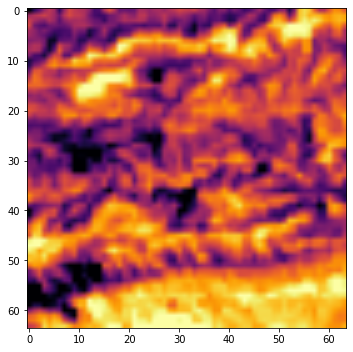

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
dl.scenes.display(l8_stack[-1,0,::], colormap='inferno', size=5) 

Now we can plot the average temperature of this location over the last year.

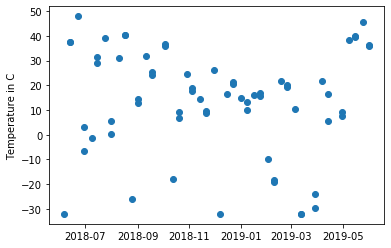

In [10]:
dates = [s.properties.date for s in scenes]
plt.plot_date(dates, np.ma.median(l8_stack[:,0,::], axis=[1, 2]))
plt.ylabel('Temperature in C')
pass

We see some extremely cold points even during the summer. The most likely culprit is that the ground was obscured by clouds which can be much colder. Let's filter out scenes with extensive cloud cover. Landsat-8 had a band that serves as a cloud mask.

In [11]:
l8_cloud = scenes.stack(bands=['cloud-mask'],   ctx=tile)
l8_vis   = scenes.stack(bands='red green blue', scaling=[(0, 5000)] * 3, ctx=tile, bands_axis=-1)

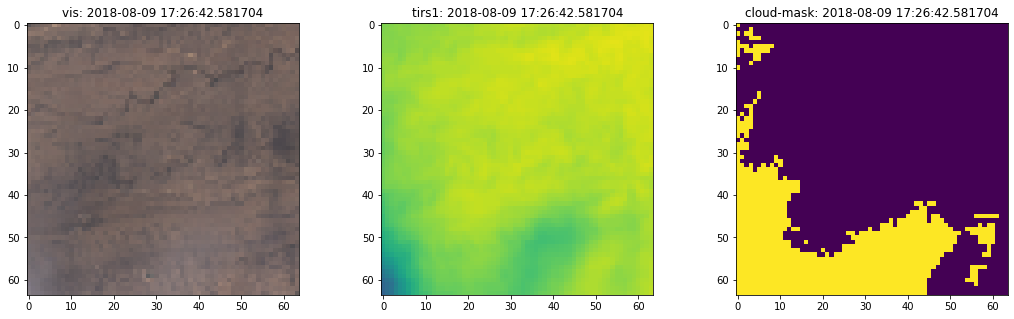

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
i = 4
ax[0].imshow(l8_vis[i,::])
ax[1].imshow(l8_stack[i,0,::], clim=(-32, 40))
ax[2].imshow(l8_cloud[i,0,::], clim=(0, 1))
ax[0].set_title('vis: ' + str(scenes[i].properties.date))
ax[1].set_title('tirs1: ' + str(scenes[i].properties.date))
ax[2].set_title('cloud-mask: ' + str(scenes[i].properties.date))
pass

The lower left corner is much colder than the rest of the scene and which is also the area covered by cloud. Let's mask out the cloudy pixels and filter to only scenes with fewer than 90% masked pixels.

In [13]:
masked_stack = np.ma.array([np.ma.array(l8_stack[i,0,::], mask=(l8_cloud[i,0,::] >= 1)) for i in range(len(scenes))])

In [14]:
n = np.array([masked_stack[i,::].count() for i in range(len(masked_stack))])
threshold = 0.1 * 64  * 64
masked_stack = masked_stack[n > threshold]

In [15]:
masked_stack.shape

(41, 64, 64)

About 20 scenes were mostly cloudy. Let's look at the rest of the data.

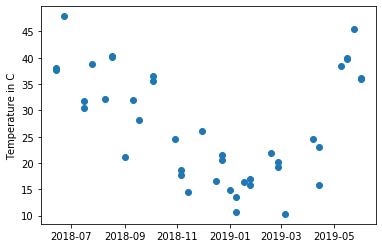

In [16]:
dates = np.array(dates)
dates = dates[n > threshold]
plt.plot_date(dates, np.ma.median(masked_stack, axis=[1, 2]))
plt.ylabel('Temperature in C')
pass

The data after cloud masking is much cleaner. The temperature variations between summer and winter are also easier to see.

##  Creating New Catalogs
___________

Now that we have transformed, masked, and cleaned our data. we can save our data as an Catalog product. That way we can reuse this data or share it with others. To create a new product we will use the [add_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.add_product) method. 

In [17]:
name = 'landsat-8-temps-1'
catalog.add_product(
    product_id=name, 
    title='Landsat-8 Temperature Demo', 
    description='Landsat8 temperatures with cloud masks'
)
pass

Catalogs that are created by you can be found with ids that are prepended by a special user hash. These ids are useful as a way to retrieve the original product at a later time with [get_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.get_product).

In [18]:
p = catalog.get_product(dl.Auth().namespace + ':' + name)
p

{'data': {'attributes': {'description': 'Landsat8 temperatures with cloud masks',
   'owners': ['user:4c8551de2725dfa98948b95bb4da87b267772935',
    'org:descarteslabs'],
   'read': [],
   'title': 'Landsat-8 Temperature Demo',
   'writers': []},
  'id': '4c8551de2725dfa98948b95bb4da87b267772935:landsat-8-temps-1',
  'meta': {'modified': '2019-08-13T23:09:47.162672+00:00',
   'owner_type': 'user'},
  'type': 'product'}}

Once we have created a product, we can add bands. The *alpha* band is a special band that designates valid or invalid data. We will upload the cloud mask to the alpha band, but make sure to invert the mask so that it represents valid data.

In [19]:
bands = [
    {
        'name': 'temp',
        'type': 'derived',
        'dtype': 'Float32',
        'data_range': [-32, 64],
    },
    {
        'name': 'alpha',
        'type': 'mask',
        'dtype': 'Byte',
        'data_range': [0, 1]
    }
]

In [20]:
for i, b in enumerate(bands):
    catalog.add_band(product_id=p['data']['id'], srcband=(i + 1), **b)

Once we have created the bands, we can access their metadata with [get_band](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.get_band).

In [21]:
catalog.get_band(p['data']['id'], bands[0]['name'])

{'data': {'attributes': {'data_range': [-32, 64],
   'default_range': [-32, 64],
   'dtype': 'Float32',
   'jpx_layer': 0,
   'name': 'temp',
   'nodata': None,
   'owners': ['user:4c8551de2725dfa98948b95bb4da87b267772935',
    'org:descarteslabs'],
   'read': [],
   'res_factor': 1,
   'srcband': 1,
   'srcfile': 0,
   'type': 'derived',
   'wavelength_unit': None,
   'writers': []},
  'id': '4c8551de2725dfa98948b95bb4da87b267772935:landsat-8-temps-1:temp',
  'meta': {'modified': '2019-08-13T23:09:48.331537+00:00',
   'owner_type': 'user'},
  'relationships': {'product': {'data': {'id': '4c8551de2725dfa98948b95bb4da87b267772935:landsat-8-temps-1',
     'type': 'product'}}},
  'type': 'band'}}

Let's reshape the masked array to the right shape. The first band will be the data and the second band is the inverted mask (the alpha band is coded 1 for valid data and 0 for invalid data). The last axis of an ndarray stores the two bands.

In [22]:
masked_bands = np.array([np.stack((arr, ~arr.mask)) for arr in masked_stack])
masked_bands = np.moveaxis(masked_bands, 1, -1)

In [23]:
masked_bands.shape

(41, 64, 64, 2)

Now we can upload our scenes into the catalog we created. For a small number of scenes we can loop over the arrays and upload our data using [upload_ndarray](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.upload_ndarray). For uploading many scenes asyncronously, consider using Tasks (which is covered in another notebook). 

In [24]:
for i, arr in enumerate(masked_bands):
    catalog.upload_ndarray(
        ndarray=arr,
        product_id=p['data']['id'],
        image_id=tile.key + ':' + str(i),
        proj4=tile.proj4,
        geotrans=tile.geotrans,
        acquired=str(dates[i])
    )

Once we have uploaded our scenes, we can retrieve them using Scenes.

In [25]:
new_scenes, ctx = dl.scenes.search(tile, products=[p['data']['id']], start_datetime='2018-06-01', end_datetime='2019-06-01', sort_field='acquired')

In [26]:
new_scenes

SceneCollection of 21 scenes
  * Dates: Jun 13, 2018 to May 24, 2019
  * Products: 4c8551de2725dfa98948b95bb4da87b267772935:landsat-8-temps-1: 21

Let's look at the data with [scenes.mosaic](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scenecollection.html#descarteslabs.scenes.scenecollection.SceneCollection.mosaic). Mosaic will try to fill in missing data (data masked by the alpha band) by combining all the scenes in a SceneCollection.

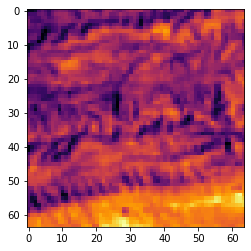

In [27]:
plt.imshow(np.squeeze(new_scenes.mosaic(bands='temp', ctx=ctx, bands_axis=-1)), cmap='inferno')
pass

Finally, we can remove the product and all of its images using the [remove_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.remove_product) function.

In [28]:
catalog.remove_product(p['data']['id'], cascade=True)
pass

## Wrap Up
_______________

We have done an analysis of ground temperature with Landsat-8 and saved our results to a new catalog product. In the process we have:

* Used [catalog.get_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.get_product) to get information about products.

* Used [catalog.add_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.add_product) to make a new product.

* Used [catalog.add_band](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.add_band) to add bands to a product.

* Used [catalog.get_band](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.get_band) to get information about bands in a product

* Used [catalog.upload_ndarray](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.upload_ndarray) to upload data to a product.

* Used [catalog.remove_product](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html#descarteslabs.client.services.catalog.Catalog.remove_product) to remove a product.

## Resources
________________

[1] [Landsat-8 product](https://catalog.descarteslabs.com/?/product/landsat:LC08:01:T1:TOAR).

[2] [Catalog documentation](https://docs.descarteslabs.com/descarteslabs/client/services/catalog/readme.html)